# 1. Логистическая регрессия

In [3]:
import pandas as pd

# Если хотите перезапустить модели, замените пути до файлов fashion-mnist.
train_data = pd.read_csv('/gdrive/My Drive/ML/w6_project/fashion-mnist_train.csv')
test_data = pd.read_csv('/gdrive/My Drive/ML/w6_project/fashion-mnist_test.csv')

train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0


In [0]:
labels = {0: 'T-shirt/top',
          1: 'Trouser',
          2: 'Pullover',
          3: 'Dress',
          4: 'Coat',
          5: 'Sandal',
          6: 'Shirt',
          7: 'Sneaker',
          8: 'Bag',
          9: 'Ankle boot'}

Подготовка данных:

In [0]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

np.random.seed(42)

num_classes = 10

# Данные для тренировки
x_train = train_data.iloc[:, 1:] / 255
y_train = train_data['label']

# Данные для итоговой проверки качества модели
x_test = test_data.iloc[:, 1:] / 255
y_test = test_data['label']

# Выделение из тренировочных данных валидационной выборки
X_tr, x_val, Y_tr, y_val = train_test_split(x_train, y_train,
                                            test_size=0.2, random_state=42)

Y_tr = tf.keras.utils.to_categorical(Y_tr, num_classes=num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)


9 случайных картинок из датасета.

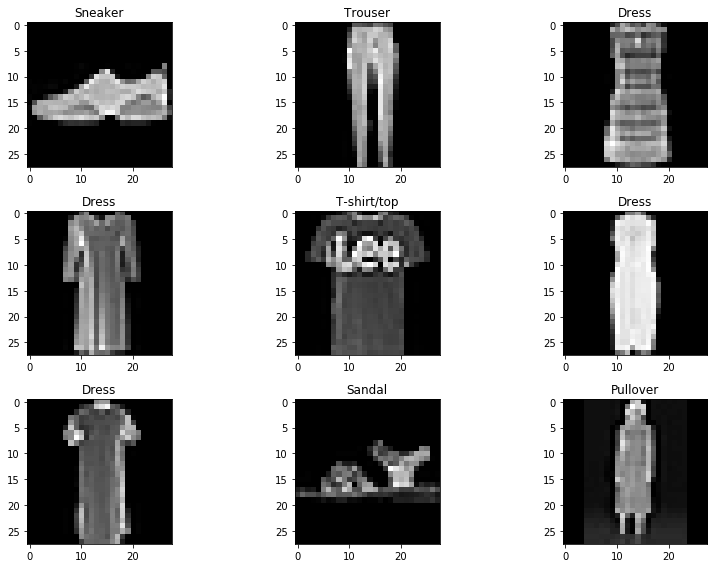

In [20]:
import matplotlib.pyplot as plt
import random


fig, ax = plt.subplots(3, 3, figsize=(12, 8))
plt.gray()

for i in range(3):
  for j in range(3):
    rand_idx = random.randint(0, 60000)
    rand_img = x_train.loc[rand_idx, :].values.reshape((28, 28))
    label = labels[y_train[rand_idx]]
    ax[i][j].imshow(rand_img)
    ax[i][j].set_title(label)

fig.tight_layout()

Построение регрессионной модели как нейросети без скрытых слоев:

In [22]:
num_classes = 10
input_shape = (784,)

def regression_network(num_classes, input_shape):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(num_classes,
                                  input_shape=input_shape,
                                  activation='softmax'))
  model.compile(
      loss='categorical_crossentropy',
      optimizer=tf.keras.optimizers.SGD(),
      metrics=['accuracy']
  )
  return model

regr_nn_model = regression_network(num_classes, input_shape)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [23]:
regr_nn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


Вспомогательная функция для построения графика:


In [0]:
def get_models_accuracy(batch_size, epochs):
  model = regression_network(num_classes=num_classes, input_shape=input_shape)
  trained = model.fit(
      X_tr, Y_tr,
      batch_size=batch_size,
      epochs=epochs,
      verbose=0,
      validation_data=(x_val, y_val)
  )
  return trained.history['val_acc']

Результаты обучения моделей для разных размеров batch_size:


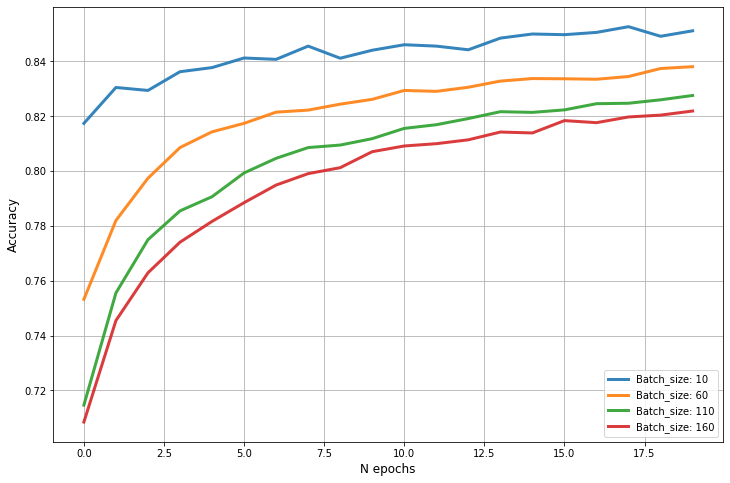

In [25]:
fig, ax = plt.subplots(figsize=(12, 8))

epochs = 20

for batch_size in range(10, 200, 50):
  acc = get_models_accuracy(batch_size, epochs)
  ax.plot(range(epochs), acc,
          linewidth=3,
          label=f'Batch_size: {batch_size}',
          alpha=0.9)

ax.set_xlabel('N epochs', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.legend()
ax.grid()

Уменьшение размера батча приводит к росту точности, плата за это - увеличение длительности вычислений. Можно полагать, что оптимальный размер батча между 10 и 60. Далее положим его равным 20 и обучим финальную модель.

In [0]:
model = regression_network(num_classes, input_shape)
trained = model.fit(
    X_tr, Y_tr,
    batch_size=20,
    epochs=20,
    verbose=0,
    validation_data=(x_val, y_val)
)

Итогова оценка качества модели:

In [29]:
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 0s 31us/sample - loss: 0.4407 - acc: 0.8506


[0.44069296255111695, 0.8506]



---



# 2. Полносвязная нейронная сеть

Сравним три полносвязных модели:
1. Один скрытый слой.
2. Два скрытых слоя.
3. Два скрытых слоя с дропаутом.

In [0]:
def one_h_layer(n_neurons, num_classes):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(n_neurons,
                                  input_shape=(784,),
                                  activation='relu'))
  model.add(tf.keras.layers.Dense(num_classes,
                                  activation='softmax'))
  model.compile(
      loss='categorical_crossentropy',
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy']
  )
  return model
    
def two_h_layers(n_neurons, num_classes):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(n_neurons,
                                  input_shape=(784,),
                                  activation='relu'))
  model.add(tf.keras.layers.Dense(n_neurons,
                                  activation='relu'))
  model.add(tf.keras.layers.Dense(num_classes,
                                  activation='softmax'))
  model.compile(
      loss='categorical_crossentropy',
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy']
  )
  return model

def two_h_layers_with_dropout(n_neurons, num_classes, drop_rate=0.5):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(n_neurons,
                                  input_shape=(784,),
                                  activation='relu'))
  model.add(tf.keras.layers.Dropout(drop_rate))
  model.add(tf.keras.layers.Dense(n_neurons,
                                  activation='relu'))
  model.add(tf.keras.layers.Dropout(drop_rate))
  model.add(tf.keras.layers.Dense(num_classes,
                                  activation='softmax'))
  model.compile(
      loss='categorical_crossentropy',
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy']
      )
  return model

def get_models_accuracy_2(model):
  trained = model.fit(
      X_tr, Y_tr,
      batch_size=batch_size,
      epochs=epochs,
      verbose=0,
      validation_data=(x_val, y_val)
  )
  return trained.history['val_acc']

Результаты обучения моделей при одинаковых размерах batch_size и одинаковом количестве эпох:

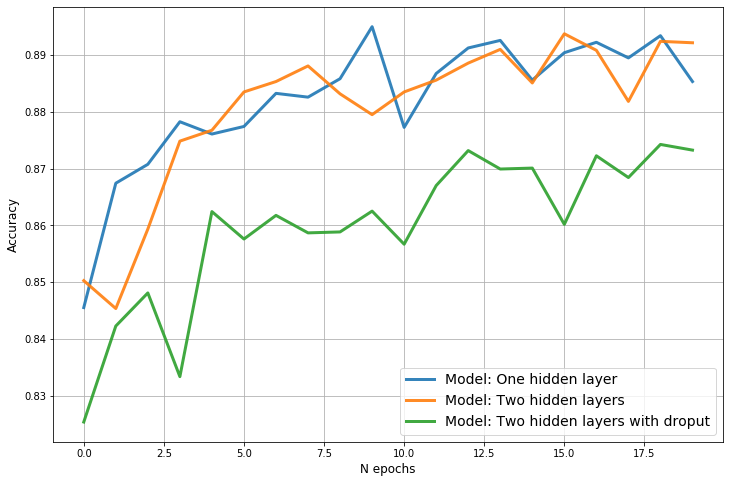

In [33]:
import matplotlib.pyplot as plt

n_neurons = 200
num_classes = 10
batch_size = 20
epochs = 20

models = [one_h_layer(n_neurons, num_classes),
          two_h_layers(n_neurons, num_classes),
          two_h_layers_with_dropout(n_neurons, num_classes)]
models_descr = ['One hidden layer',
                'Two hidden layers',
                'Two hidden layers with droput']


fig, ax = plt.subplots(figsize=(12, 8))

for model, model_descr in zip(models, models_descr):
  acc = get_models_accuracy_2(model)
  ax.plot(range(epochs), acc,
          linewidth=3,
          label=f'Model: {model_descr}',
          alpha=0.9)

ax.set_xlabel('N epochs', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.legend(fontsize=14)
ax.grid()

Модели с одним и с двумя скрытыми слоями показывают примерно оиднаковое качество. Моедель с дропаутом, выглядит хуже. Возможно дропаут оказался не эффективен при данной архитектуре сети. Возможно, что эффективность дропаута проявится позже, при более длительном обученнии, когда сети без дропаута начнут преобучаться. Далее выполним оценку на тестовой выборке для сети с одним скрытым слоем.

In [0]:
model = one_h_layer(n_neurons, num_classes)

trained = model.fit(
    X_tr, Y_tr,
    batch_size=batch_size,
    epochs=epochs,
    verbose=0
)

In [35]:
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 56us/sample - loss: 0.3681 - acc: 0.8890


[0.36811412832736967, 0.889]

Качество сети с одинм скрытым слоем примерно на 3% лучше, чем у регрессионной модели. Это объясняется большим количеством свободных параметров модели, что позволяет улавливать больше паттернов в данных.






---



# 3. Сверточная нейронная сеть

Подготовка данных:

In [0]:
X_tr = X_tr.values.reshape((-1, 28, 28, 1))
x_val = x_val.values.reshape((-1, 28, 28, 1))
x_test = x_test.values.reshape((-1, 28, 28, 1))

Сравним три модели:
1. Один сверточный слой и maxpool.
2. Два сверточных слоя с maxpool.
3. Два сверточных слоя с maxpool и нормализацией после сверточных слоев.

In [0]:
def one_conv_layer(num_classes):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Convolution2D(filters=32,
                                          kernel_size=(3, 3),
                                          activation='relu',
                                          input_shape=(28, 28, 1)))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(64, activation='relu'))
  model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
  model.compile(
      loss='categorical_crossentropy',
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy']
  )
  return model


def two_conv_layer(num_classes):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Convolution2D(filters=32,
                                          kernel_size=(3, 3),
                                          activation='relu',
                                          input_shape=(28, 28, 1)))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.Convolution2D(filters=64,
                                          kernel_size=(3, 3),
                                          activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(64, activation='relu'))
  model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
  model.compile(
      loss='categorical_crossentropy',
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy']
  )
  return model


def two_conv_layer_norm(num_classes):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Convolution2D(filters=32,
                                          kernel_size=(3, 3),
                                          activation='relu',
                                          input_shape=(28, 28, 1)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.Convolution2D(filters=64,
                                          kernel_size=(3, 3),
                                          activation='relu'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(64, activation='relu'))
  model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
  model.compile(
      loss='categorical_crossentropy',
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy']
  )
  return model

Результаты обучения разных моделей при одинаковом размере batch_size и одинаковом количестве эпох:

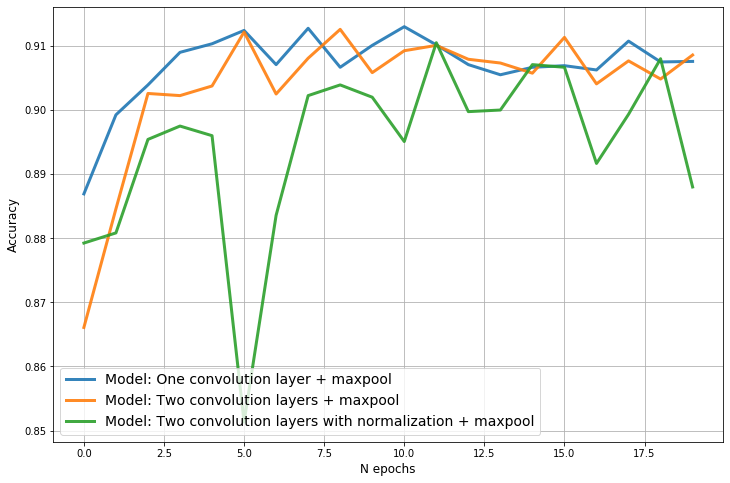

In [38]:
import matplotlib.pyplot as plt

num_classes = 10
batch_size = 20
epochs = 20

models = [one_conv_layer(num_classes),
          two_conv_layer(num_classes),
          two_conv_layer_norm(num_classes)]
models_descr = ['One convolution layer + maxpool',
                'Two convolution layers + maxpool',
                'Two convolution layers with normalization + maxpool']


fig, ax = plt.subplots(figsize=(12, 8))

for model, model_descr in zip(models, models_descr):
  acc = get_models_accuracy_2(model)
  ax.plot(range(epochs), acc,
          linewidth=3,
          label=f'Model: {model_descr}',
          alpha=0.9)

ax.set_xlabel('N epochs', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.legend(fontsize=14)
ax.grid()

Модели с одним и двумя слоями показывают примерно одинаковое качество. Результаты примерно на 1% лучше, чем у полносвязных моделей из предыдущего раздела. Качество на тестовой выборке проверим на модели с одим светночным слоем после 5 эпох обучения.

In [0]:
model = one_conv_layer(num_classes)
trained = model.fit(
    X_tr, Y_tr,
    batch_size=20,
    epochs=5,
    verbose=0
)

In [13]:
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 2s 169us/sample - loss: 0.2982 - acc: 0.8996


[0.29817221986055376, 0.8996]

На тестовой выборке качество оказалось несколько ниже ожидаемого из предварительной оценки. Скорее всего при повторной реализации можно получить большую точность при том же количестве эпох.



---

